In [1]:
%load_ext autoreload
%autoreload 2

# Existing solution
references: https://pubs.acs.org/doi/10.1021/acsami.4c01401

### *None of 6 models surpasses the 90% accuracy.* 
<img src="../data/polymer/am4c01401_si_001.png" alt="model results" />
Figure 3. (a) Images of the prediction performance of ML using three types of linear regressions and three types of nonlinear regressions. (b) R2 and RMSE values of each algorithm in predicting the amount of adsorbed protein. Values for test data are shown with diagonal lines.

# My Active Learning approach

# 1. Load libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt

/Users/gbemidebe/miniconda3/envs/ActiveLearn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"
                                                ] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 13
plt.rcParams['figure.dpi'] = 300

In [4]:
# fix random seed
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.enabled = False

In [5]:
sys.path.append('..')

from src.query import RandomSampling
from src.preprocessing import Handler, Data
from src.network import Net, Regressor
from src.utils import plot_heat_map, plot_data, show_performance, runAL

# 2. Load Data

In [6]:
data = pd.read_excel('../data/polymer/am4c01401_si_001.xlsx')
data.drop(columns=['Ref.'], inplace=True)
data.head()

,Protein Adsorption (ng/cm2),Mn,Density,Thickness,Sub_Ad,pH,Temp,Pro_Conc,Ionic strength,Flow rate,Pol_Type,Mpro,Charge
0,1800.0,12000,0.74,11.04,3350.0,7.4,37,1.00,150,0.0,5.8,66000,-2.4
1,3100.0,12000,0.14,2.15,3350.0,7.4,37,1.00,150,0.0,5.8,66000,-2.4
2,220.0,12200,0.10,1.50,410.0,7.4,23,0.05,150,0.0,9.4,340000,-1.6
3,160.0,12200,0.14,2.00,410.0,7.4,23,0.05,150,0.0,9.4,340000,-1.6
4,50.0,12200,0.29,4.40,410.0,7.4,23,0.05,150,0.0,9.4,340000,-1.6


In [7]:
data.dtypes

Protein Adsorption (ng/cm2)    float64
Mn                               int64
Density                        float64
Thickness                      float64
Sub_Ad                         float64
pH                             float64
Temp                             int64
Pro_Conc                       float64
Ionic strength                   int64
Flow rate                      float64
Pol_Type                       float64
Mpro                             int64
Charge                         float64
dtype: object

In [8]:
features_col = data.columns[1:]
target_col = data.columns[0]
print('Features: ', features_col)
print('Target: ', target_col)

Features:  Index(['Mn', 'Density', 'Thickness', 'Sub_Ad', 'pH', 'Temp', 'Pro_Conc',
       'Ionic strength', 'Flow rate', 'Pol_Type', 'Mpro', 'Charge'],
      dtype='object')
Target:  Protein Adsorption (ng/cm2)


Text(0, 0.5, 'Frequency')

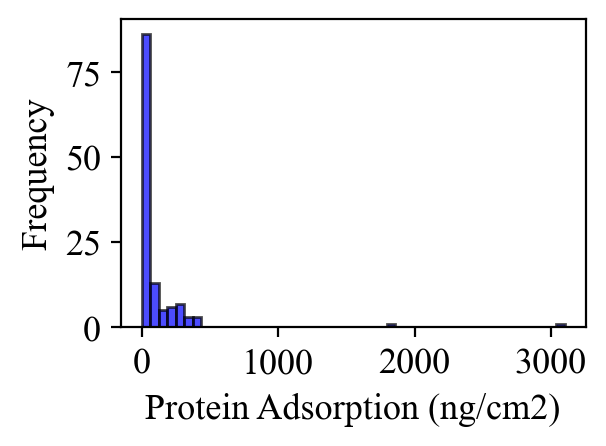

In [9]:
# data description
plt.figure(figsize=(3, 2), dpi=200)
# histogram using matplotlib
k = plt.hist(data[target_col], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel(target_col)
plt.ylabel('Frequency')

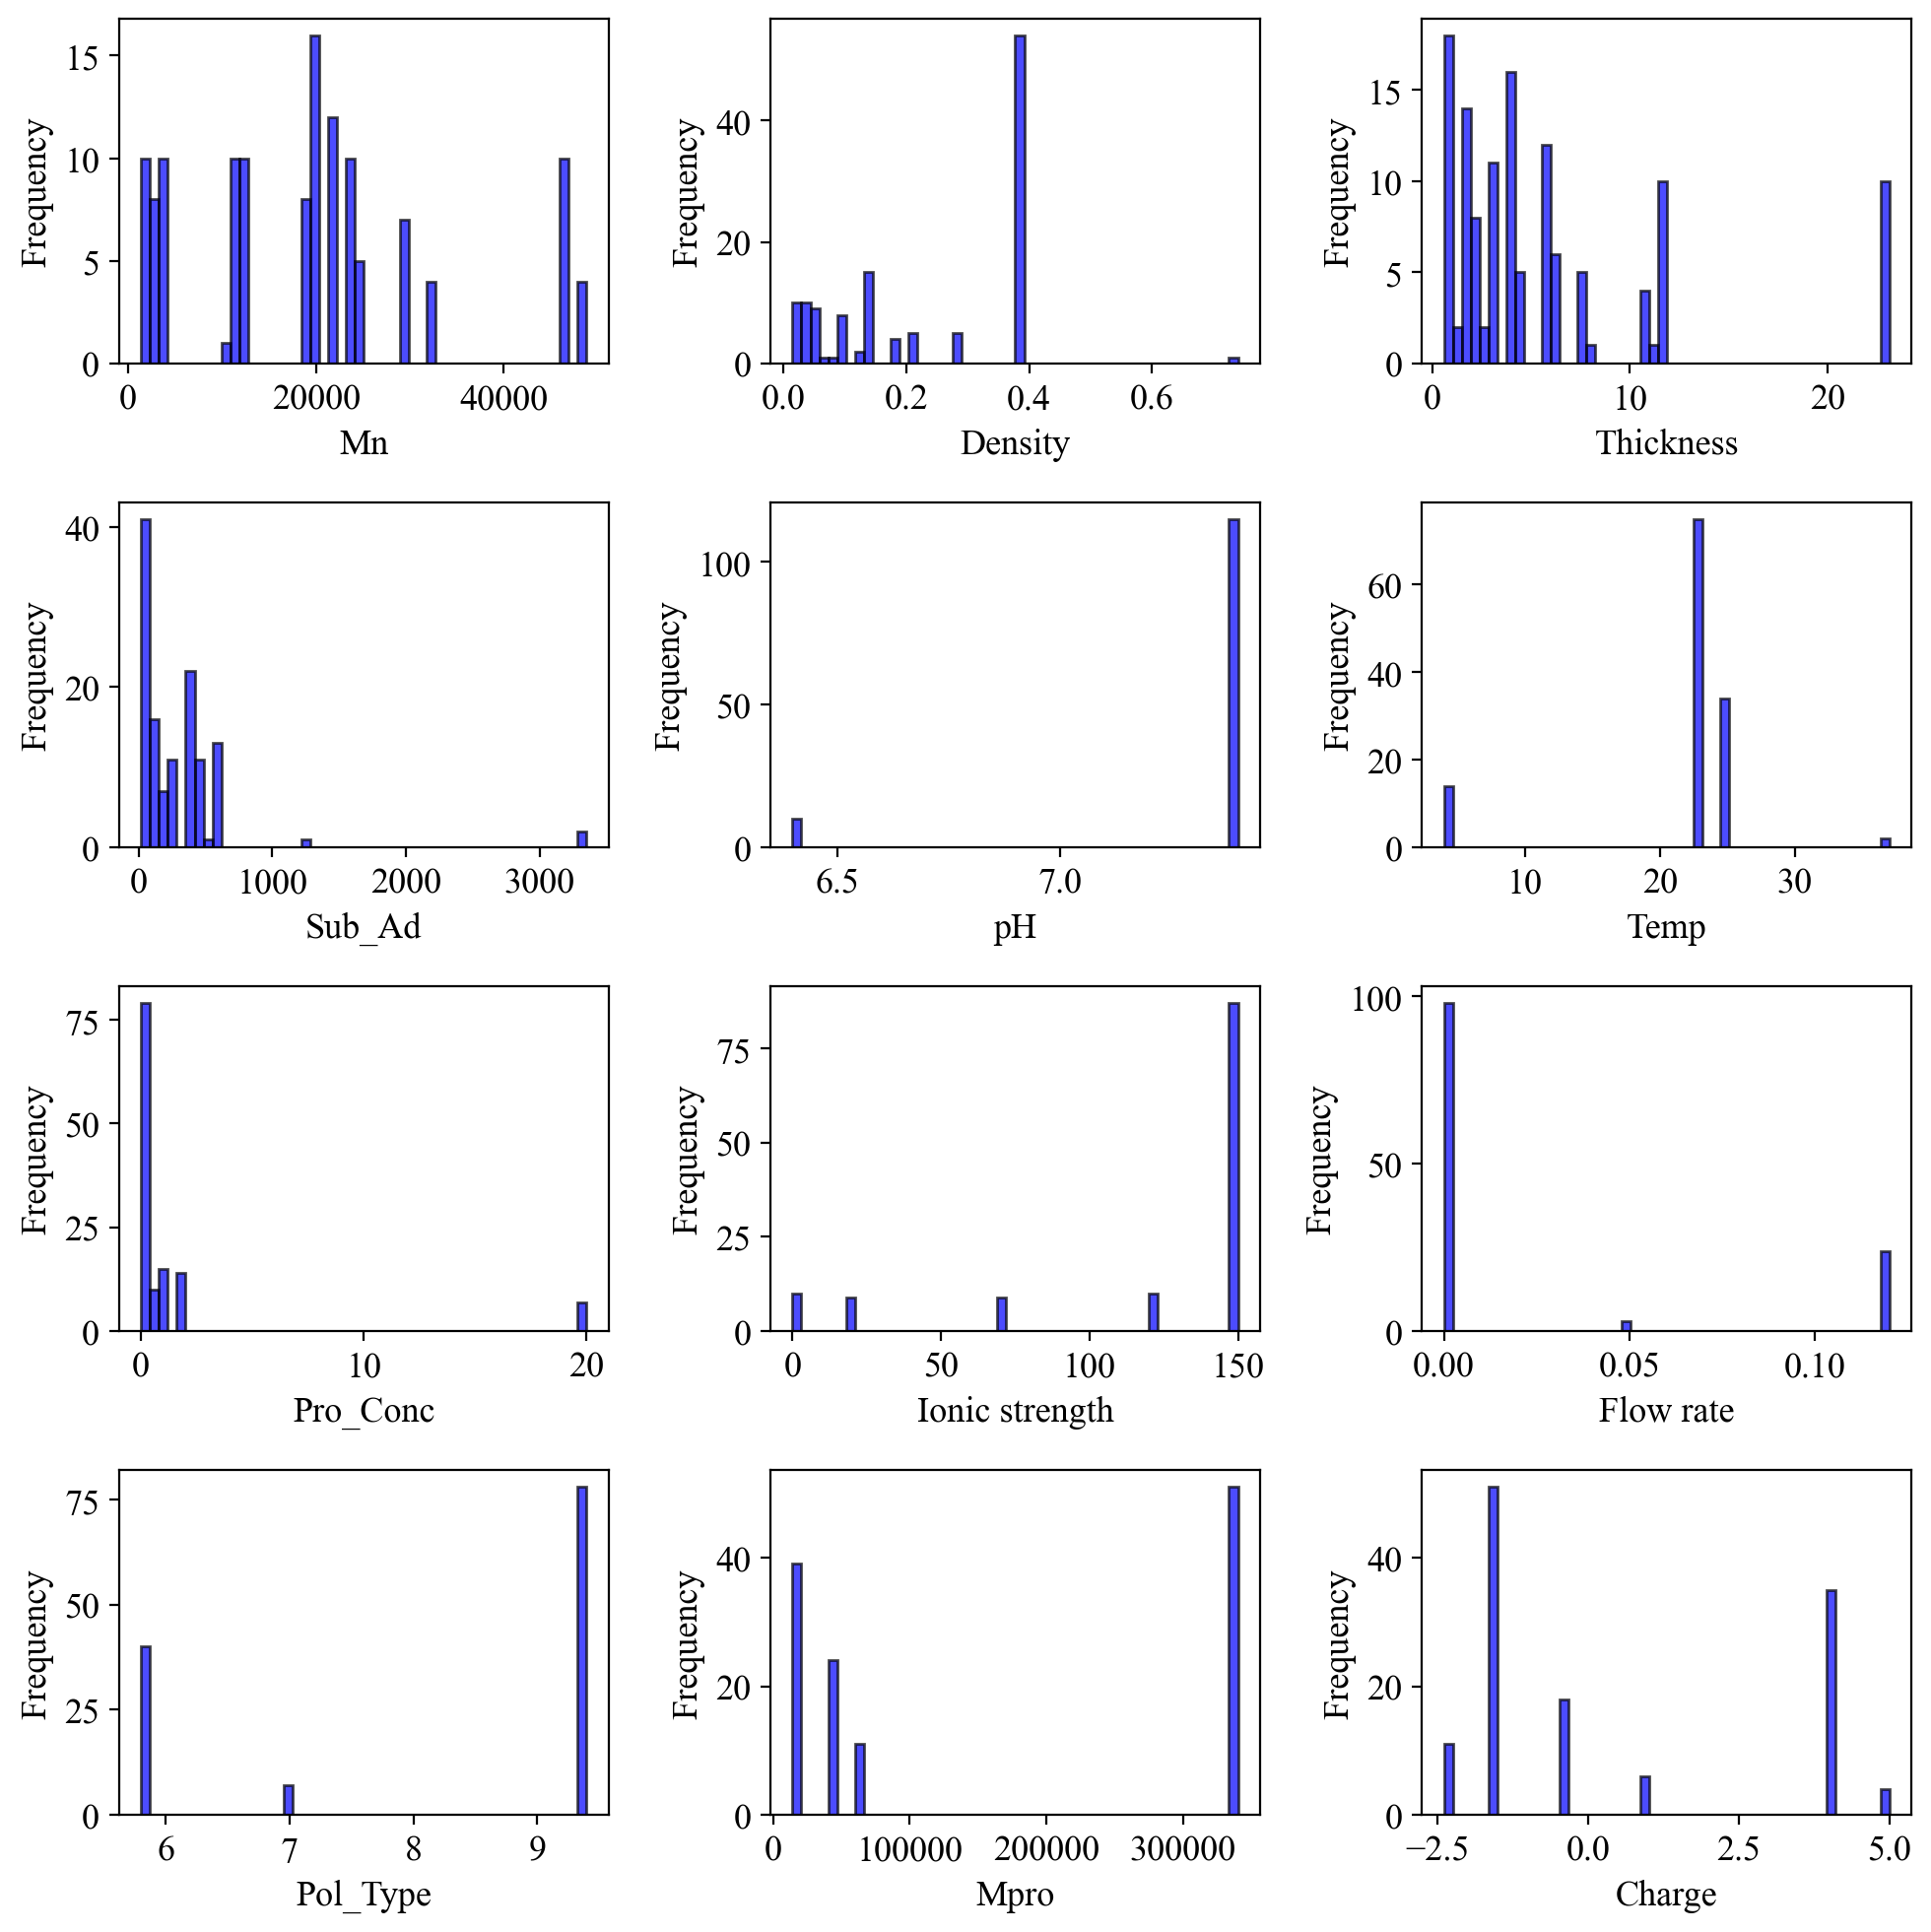

In [10]:
# show histogram for all features with subplots
plt.figure(figsize=(10, 10), dpi=200)
for i, feature in enumerate(features_col):
    plt.subplot(4, 3, i+1)
    k = plt.hist(data[feature], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()

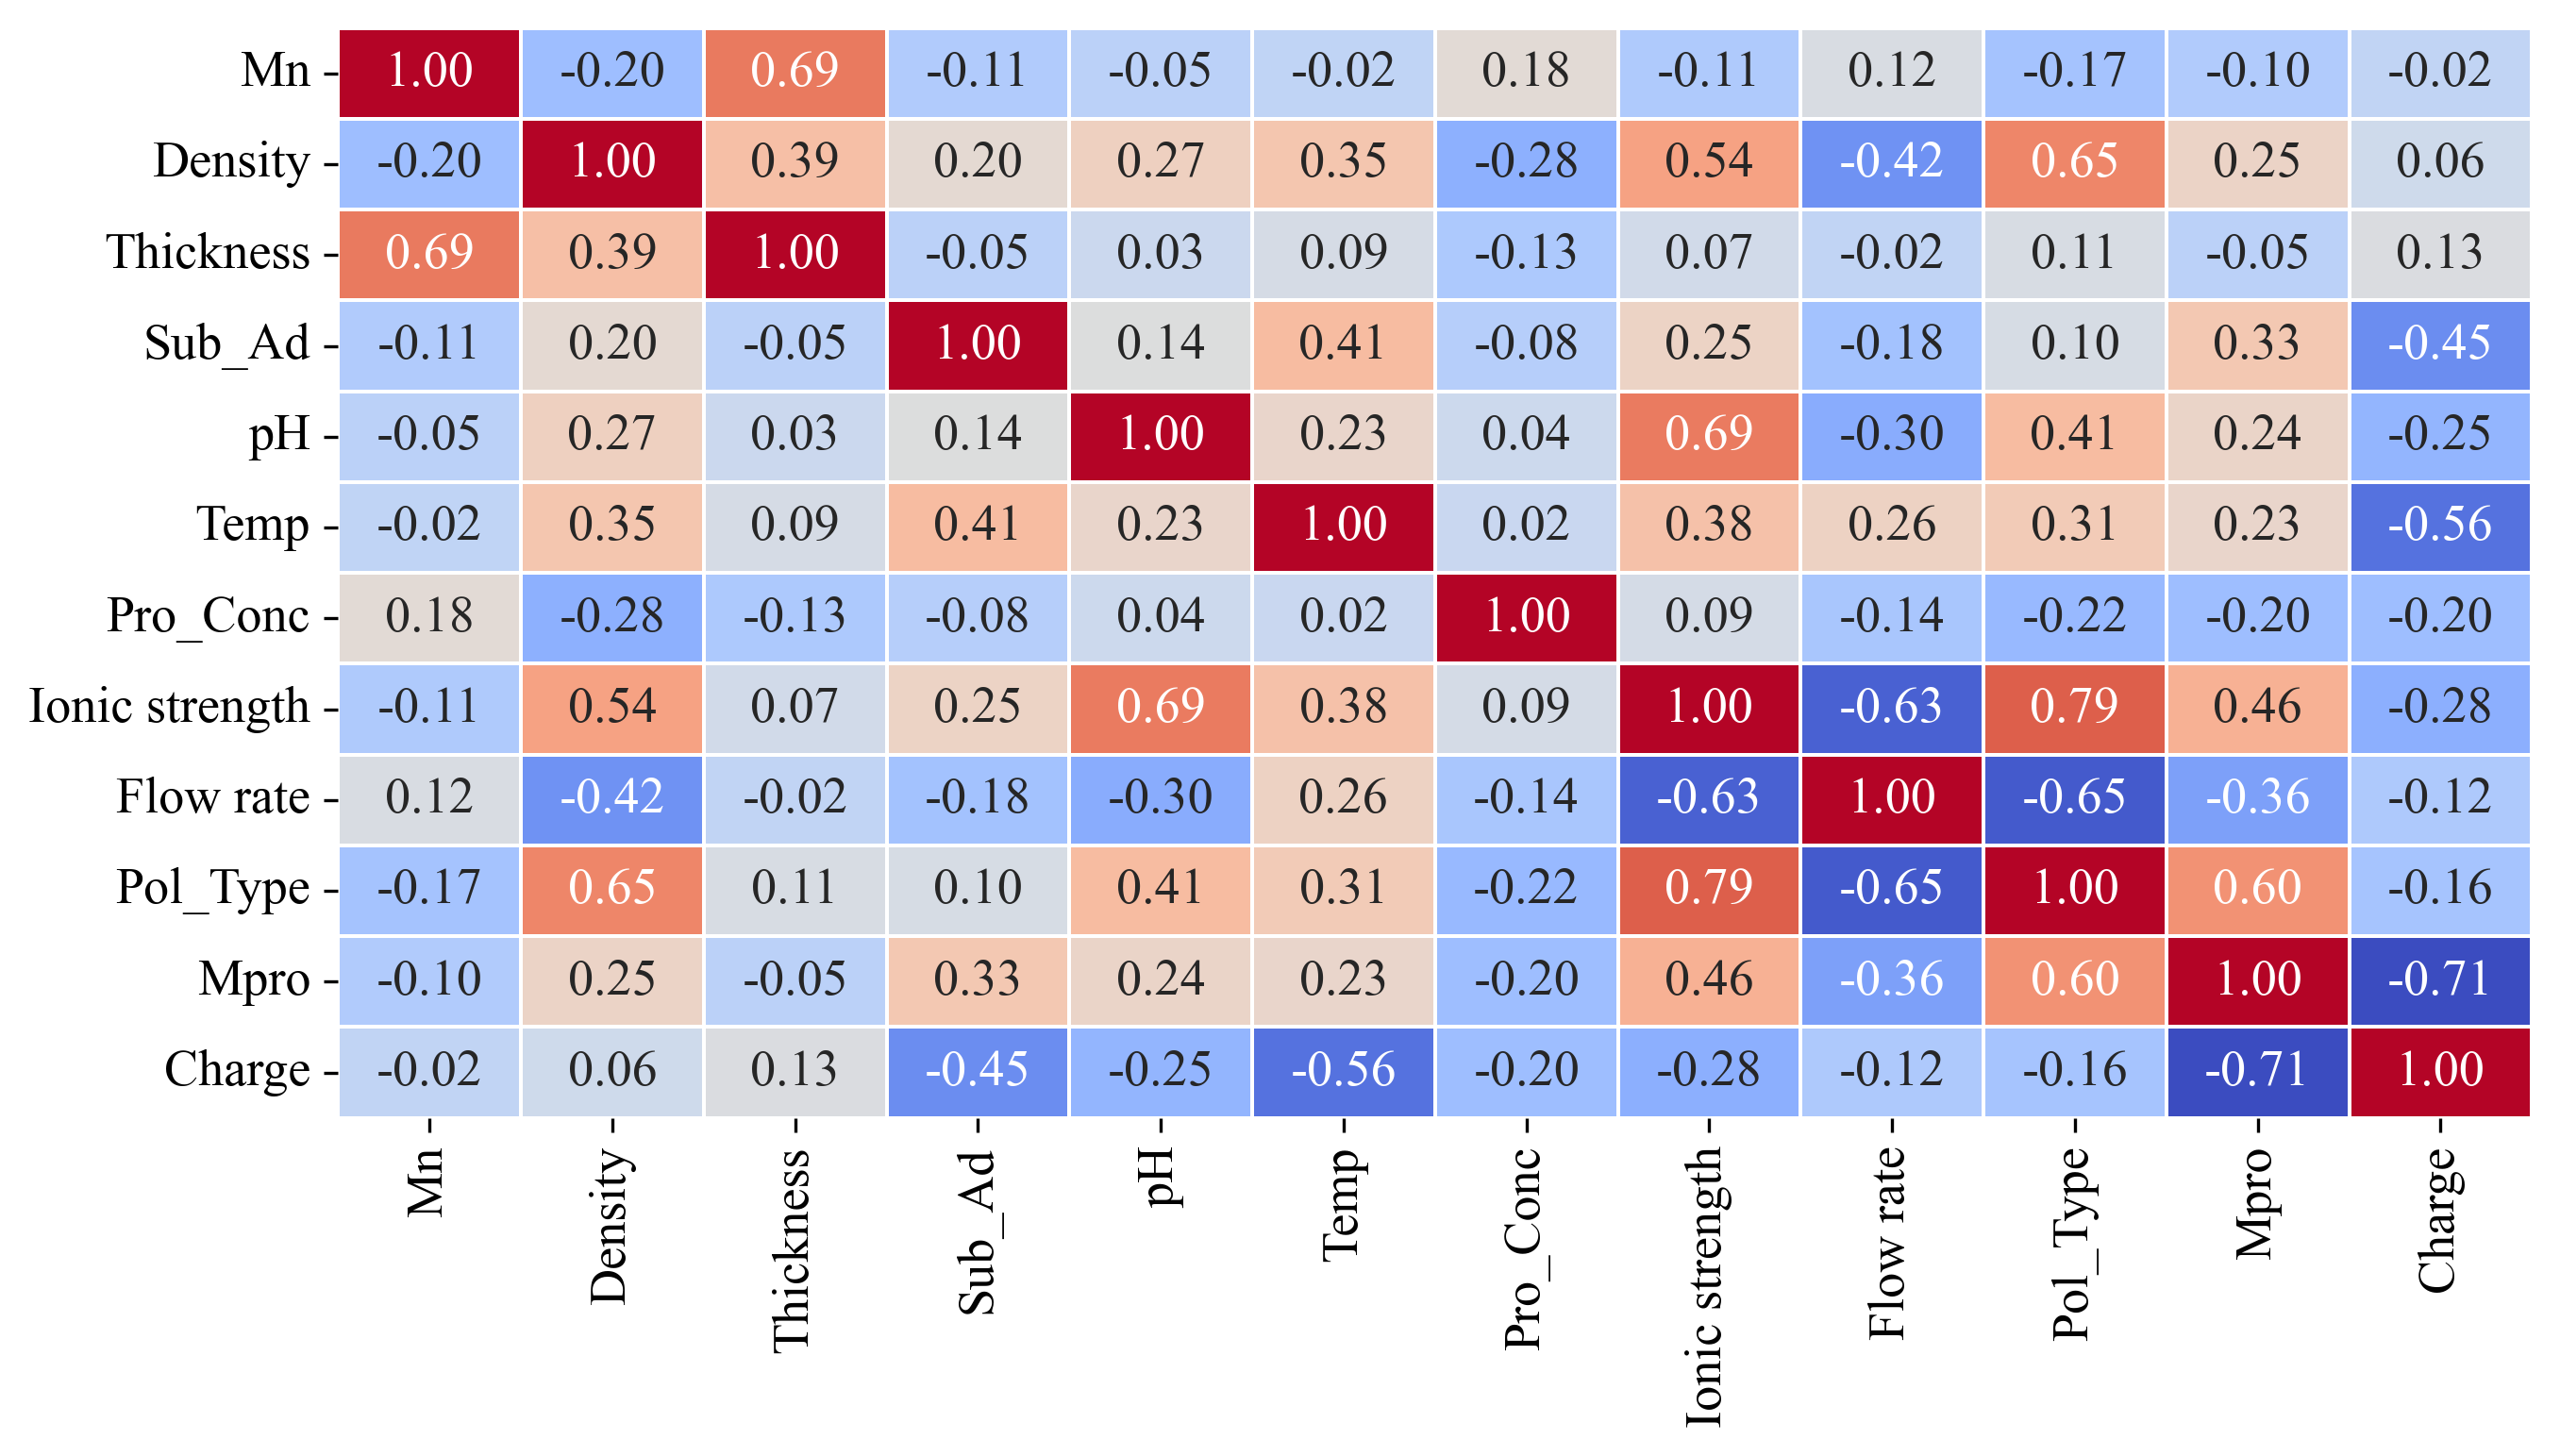

In [11]:
plot_heat_map(data = data.drop(columns=[target_col]), fig_size = (10, 5))

# 3. Model Training

In [12]:
dataset = Data(data, features_col, target_col, test_size=0.2, random_state=42, handler=Handler)

Scaling the data
Splitting the data


In [13]:
# params
params =  {'n_epoch': 100, 
               'train':{'batch_size': 32},
               'test':{'batch_size': 32},
               'optim':{'lr': 0.001, 'amsgrad': False}}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net =  Net(net=Regressor(input_dim=len(features_col), n_hidden_size=32),
           params=params, device=device)
           
# start experiment
n_init_labeled = 10
dataset.initialize_labels(n_init_labeled)
print(f"number of labeled pool: {n_init_labeled}")
print(f"number of unlabeled pool: {dataset.n_pool - n_init_labeled}")
print(f"number of testing pool: {dataset.n_test}")
print()

number of labeled pool: 10
number of unlabeled pool: 90
number of testing pool: 25



## A. Random Sampling

In [14]:
# the strategy to query the data
randomstrategy = RandomSampling(dataset, net)  # load strategy

In [15]:
# first training
randomstrategy.train()

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3397.52it/s]


In [16]:
random_train, random_test = runAL(strategy=randomstrategy, dataset=dataset, n_round=10, n_query=8)

Round 0


  0%|                                                                       | 0/100 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3477.43it/s]


Round 0 accuracy --> Train: 0.10313016307973644 Test: 0.033839870652837556
Round 1


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3300.47it/s]


accuracy --> Train: 0.101 Test: -0.002
rmse --> Train: 300.328 Test: 356.279
mae --> Train: 77.489 Test: 127.750
evs --> Train: 0.102 Test: 0.015
Round 2


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3187.33it/s]


accuracy --> Train: 0.160 Test: -0.016
rmse --> Train: 290.219 Test: 358.733
mae --> Train: 66.087 Test: 114.100
evs --> Train: 0.165 Test: 0.013
Round 3


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1818.05it/s]


accuracy --> Train: 0.403 Test: 0.127
rmse --> Train: 244.593 Test: 332.516
mae --> Train: 84.003 Test: 136.503
evs --> Train: 0.411 Test: 0.128
Round 4


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1399.27it/s]


accuracy --> Train: 0.802 Test: 0.652
rmse --> Train: 140.884 Test: 209.777
mae --> Train: 70.458 Test: 104.633
evs --> Train: 0.808 Test: 0.653
Round 5


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1643.41it/s]


accuracy --> Train: 0.941 Test: 0.938
rmse --> Train: 77.078 Test: 88.853
mae --> Train: 40.129 Test: 44.691
evs --> Train: 0.942 Test: 0.938
Round 6


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1647.04it/s]


accuracy --> Train: 0.965 Test: 0.960
rmse --> Train: 59.459 Test: 71.469
mae --> Train: 32.162 Test: 43.051
evs --> Train: 0.965 Test: 0.960
Round 7


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1076.24it/s]


accuracy --> Train: 0.972 Test: 0.970
rmse --> Train: 53.132 Test: 61.585
mae --> Train: 30.940 Test: 39.828
evs --> Train: 0.974 Test: 0.970
Round 8


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1127.84it/s]


accuracy --> Train: 0.977 Test: 0.964
rmse --> Train: 47.562 Test: 67.912
mae --> Train: 25.613 Test: 43.774
evs --> Train: 0.978 Test: 0.964
Round 9


100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1108.94it/s]


accuracy --> Train: 0.992 Test: 0.982
rmse --> Train: 27.683 Test: 48.363
mae --> Train: 17.788 Test: 32.561
evs --> Train: 0.993 Test: 0.982
Round 10


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 599.50it/s]

accuracy --> Train: 0.995 Test: 0.981
rmse --> Train: 23.460 Test: 48.934
mae --> Train: 14.606 Test: 32.478
evs --> Train: 0.995 Test: 0.982


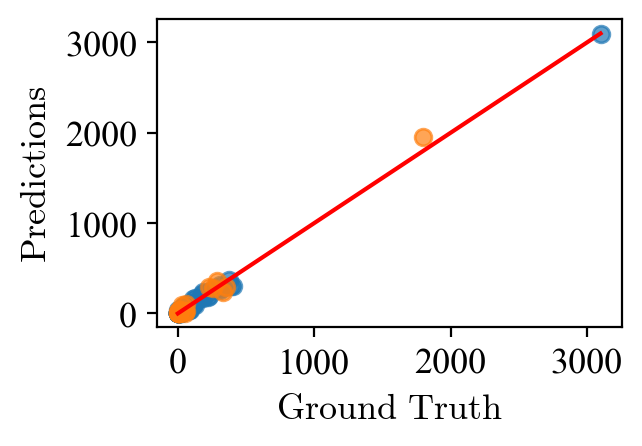

In [17]:
plot_data(random_train, random_test, data, target_col)

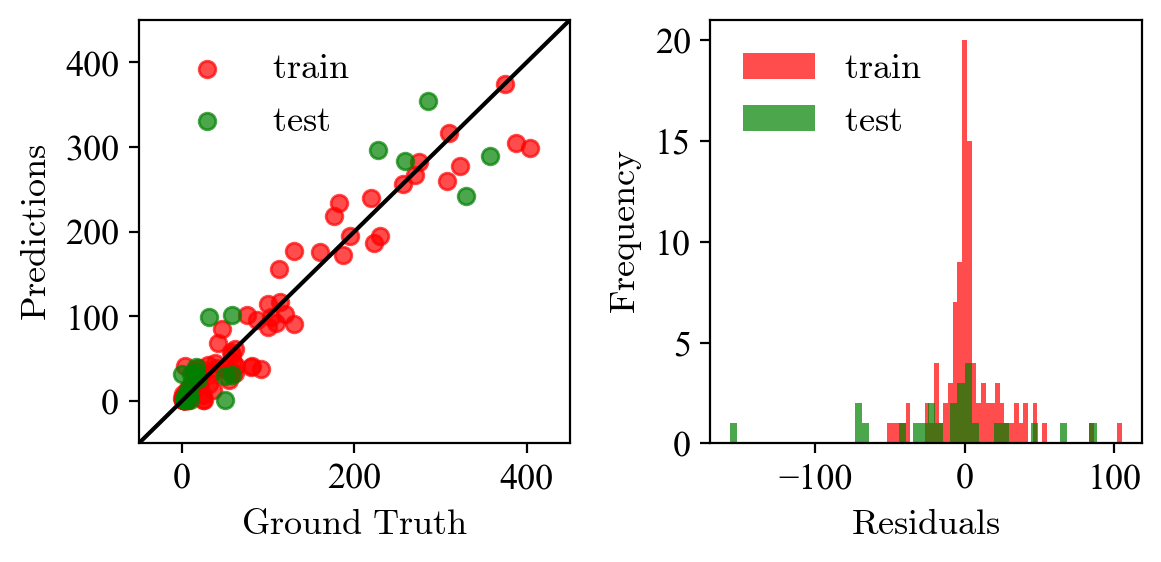

In [18]:
approach = 'Random'
show_performance(random_train, random_test, method=approach, save_fig=True)

In [20]:
# write train, test to numpy
np.save(f'../reports/data/{approach}_train.npy', np.array(random_train, dtype=object), allow_pickle=True)
np.save(f'../reports/data/{approach}_test.npy', np.array(random_test, dtype=object), allow_pickle=True)